In [ ]:
# Enhanced TensorFlow + Keras Image Classification Model
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt 
import pathlib
import os

# Constants
IMG_HEIGHT = 240
IMG_WIDTH = 240
BATCH_SIZE = 32
DATA_DIR = "../data/Set_A/Set_A/Train"

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.4),
    layers.RandomContrast(0.4),
    layers.RandomBrightness(0.4),
    layers.RandomTranslation(0.3, 0.3),
])

# Helper function to filter valid and non-corrupted image files
def filter_valid_images(directory):
    valid_extensions = {".jpg", ".jpeg", ".png", ".gif", ".bmp"}
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if not any(file.lower().endswith(ext) for ext in valid_extensions):
                print(f"Removing unsupported file: {file_path}")
                os.remove(file_path)
            else:
                try:
                    # Attempt to open the image to check for corruption
                    img = tf.io.read_file(file_path)
                    tf.image.decode_image(img)
                except Exception as e:
                    print(f"Removing corrupted file: {file_path} due to error: {e}")
                    os.remove(file_path)

# Filter unsupported files in the dataset directory
filter_valid_images(DATA_DIR)

# Load Dataset
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)
raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)

# Extract class names
class_names = raw_train_ds.class_names

# Apply Data Augmentation
train_ds = raw_train_ds.map(lambda x, y: (data_augmentation(x), y)).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = raw_val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Compute Class Weights
y_train = []
for _, labels in raw_train_ds:  # Use raw_train_ds to get labels
    y_train.extend(labels.numpy())
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train,
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Build Model
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights="imagenet")
base_model.trainable = False

# Fine-tune the base model
base_model.trainable = True

# Freeze the first few layers to retain pre-trained features
for layer in base_model.layers[:100]:
    layer.trainable = False

# Add a learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Simplify the model further by using fewer layers and freezing the base model
base_model.trainable = False  # Freeze the entire base model

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation="relu"),  # Reduced number of units
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation="softmax"),
])

# Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Increase the number of training epochs
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,  # Increased epochs
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler],
)

# Save Model
model.save("flower_model_improved.keras")

Found 280 files belonging to 21 classes.
Using 224 files for training.
Using 224 files for training.
Found 280 files belonging to 21 classes.
Using 56 files for validation.
Found 280 files belonging to 21 classes.
Using 56 files for validation.


C:\Users\Admin\AppData\Local\Temp\ipykernel_172316\1511956446.py:87: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights="imagenet")


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 492ms/step - accuracy: 0.0597 - loss: 3.5904 - val_accuracy: 0.0179 - val_loss: 3.4015 - learning_rate: 1.0000e-04
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 492ms/step - accuracy: 0.0597 - loss: 3.5904 - val_accuracy: 0.0179 - val_loss: 3.4015 - learning_rate: 1.0000e-04
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - accuracy: 0.0404 - loss: 3.4858 - val_accuracy: 0.0536 - val_loss: 3.2502 - learning_rate: 1.0000e-04
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - accuracy: 0.0404 - loss: 3.4858 - val_accuracy: 0.0536 - val_loss: 3.2502 - learning_rate: 1.0000e-04
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step - accuracy: 0.0645 - loss: 3.4044 - val_accuracy: 0.0714 - val_loss: 3.1607 - learning_rate: 1.0000e-04
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step - accuracy: 0.0645 - loss: 3.4044 - val_accuracy: 0.0714 - val_loss: 3.1607 - learning_rate: 1.0000e-04
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 316ms/step - accuracy: 0.0358 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0 Predict 20 - Hoa long den with a 4.83 percent confidence. ::REAL 0_HoaSen.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
0 Predict 20 - Hoa long den with a 4.83 percent confidence. ::REAL 0_HoaSen.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1 Predict 12 - Hong tu cau with a 4.88 percent confidence. ::REAL 10_Hoa dam but.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1 Predict 12 - Hong tu cau with a 4.88 percent confidence. ::REAL 10_Hoa dam but.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2 Predict 19 - Hoa Phao Bong with a 4.85 percent confidence. ::REAL 11_Hoa huong duong 002.jpg
2 Predict 19 - Hoa Phao Bong with a 4.85 percent confidence. ::REAL 11_Hoa huong duong 002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3 Predict 13 - Hoa oi with a 4.87 percent confidence. ::REAL 12_Hong tu cau 005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step3 Predict 13 - Hoa oi with a 4.87 percent confidence. :

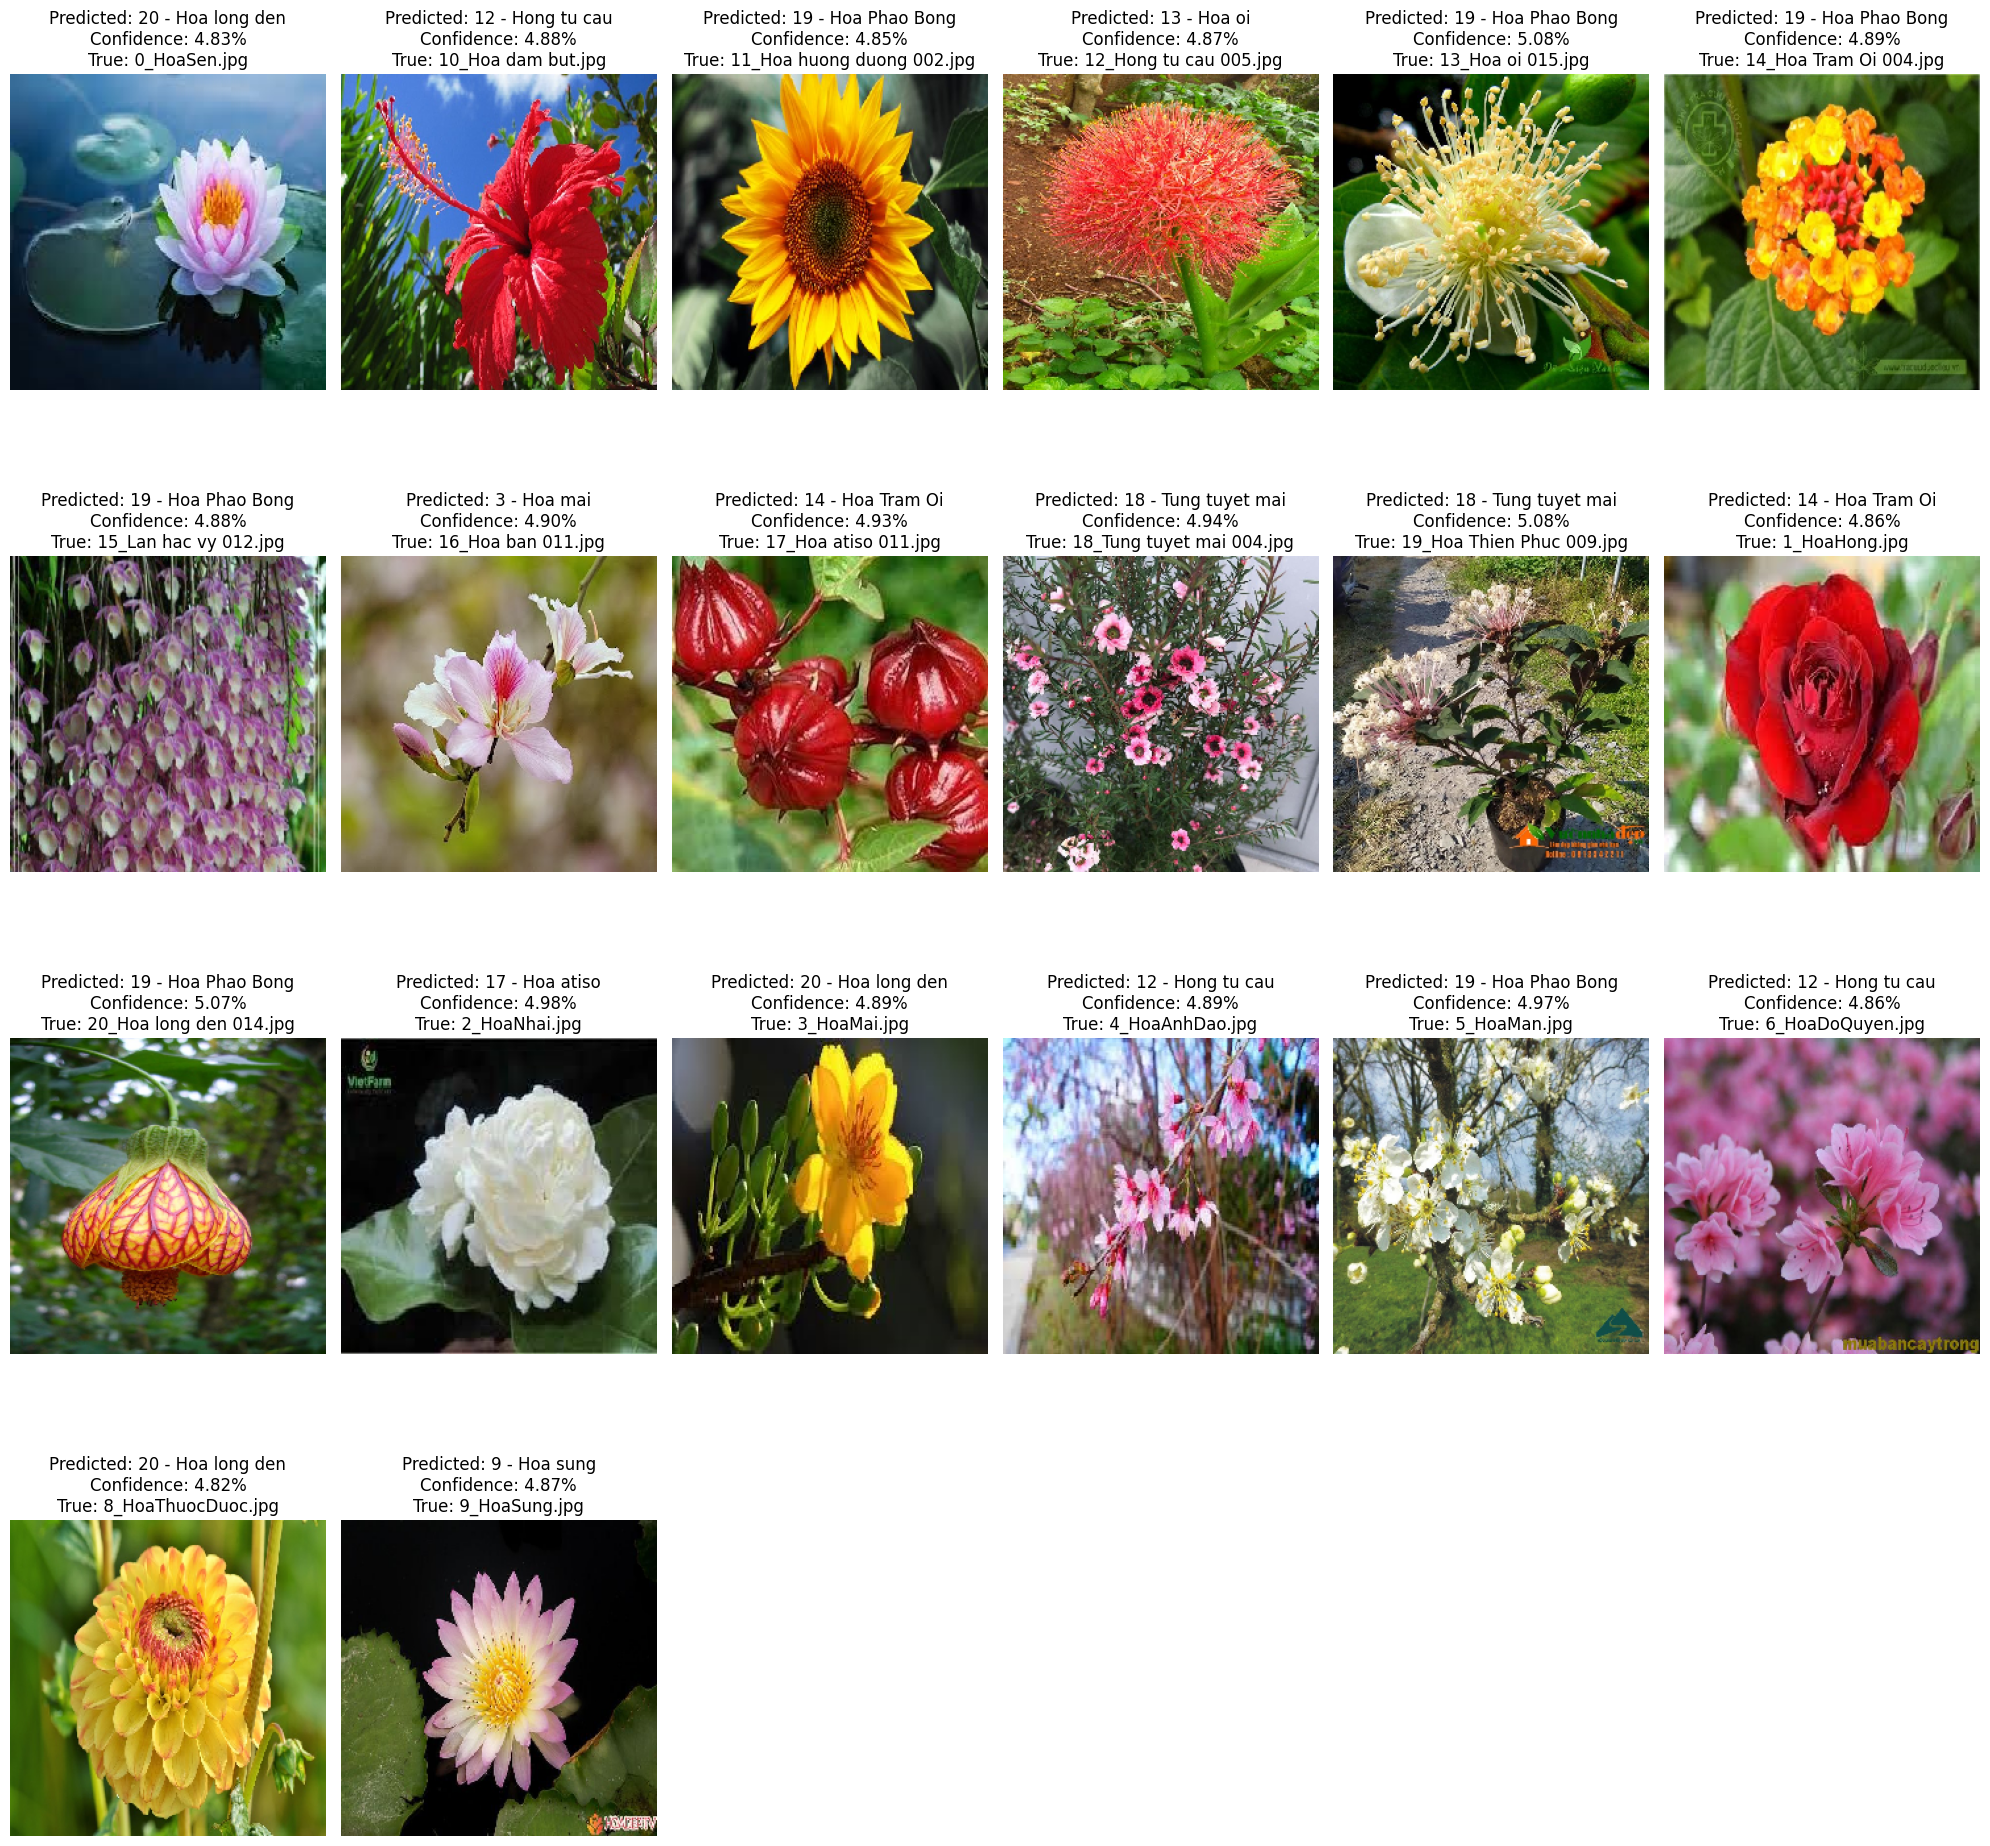

In [11]:
test_dir = pathlib.Path(r"D:\\BT\\2433_Emerging_Technologies\\data\\Set_A\\Set_A\\Test") 
listImages_test = list(test_dir.glob('*.jpg')) + list(test_dir.glob('*.webp')) + list(test_dir.glob('*.png')) + list(test_dir.glob('*.jpeg')) + list(test_dir.glob('*.jfif'))
plt.figure(figsize=(20, 20))
for i in range(len(listImages_test)):
    img = tf.keras.utils.load_img(
        listImages_test[i], target_size=(IMG_HEIGHT, IMG_HEIGHT)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    predicted_name = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)
    true_name = listImages_test[i].name  # Extract the true name from the file name
    print(i, f"Predict {predicted_name} with a {confidence:.2f} percent confidence. ::REAL {true_name}")
    plt.subplot((len(listImages_test)//6) + 1, 6, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_name}\nConfidence: {confidence:.2f}%\nTrue: {true_name}")
    plt.axis("off")

plt.tight_layout()
plt.show()